In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

## Data Preparation

### 1. Load the data

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [4]:
(train.shape, test.shape)

((42000, 785), (28000, 784))

In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 2. Split the data into Features and Labels

In [6]:
# Split features and labels for training data
X = train.iloc[:, 1:]
y = train['label']

### 3. Visualize the data

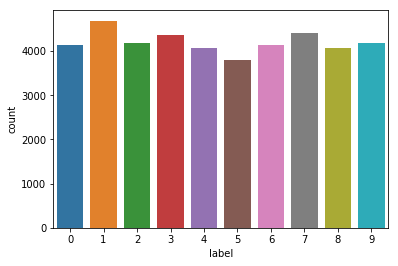

In [7]:
# Visualize the data distribution
g = sns.countplot(y)
# y.values_count()

> The labels are almost equally distributed

### 4. Normalize the data

In [8]:
X = X / 255.0
test = test / 255.0

In [9]:
X = X.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [10]:
y = tf.keras.utils.to_categorical(y, num_classes = 10)

### 5. Splitting the data into Train and Validation sets

In [11]:
seed = 10
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

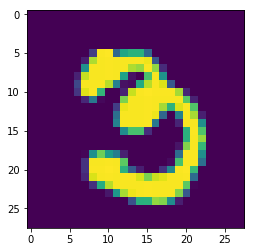

In [12]:
g = plt.imshow(x_train[0][:,:,0])

## Model

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = tf.nn.relu, input_shape = (28, 28, 1), padding='Same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation = tf.nn.relu, padding='Same'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = tf.nn.relu, padding='Same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation = tf.nn.relu, padding='Same'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(512, (3, 3), activation = tf.nn.relu, padding='Same'),
    tf.keras.layers.Conv2D(1024, (3, 3), activation = tf.nn.relu, padding='Same'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = tf.nn.relu),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation = tf.nn.softmax)
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [15]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [16]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False
)
datagen.fit(x_train)

In [17]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=64), epochs=35, 
                              validation_data=(x_test, y_test), steps_per_epoch=x_train.shape[0]//64,
                             callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.cast instead.
Epoch 1/35
591/591 [==============================] - 18s 30ms/step - loss: 0.3699 - acc: 0.8789 - val_loss: 0.0501 - val_acc: 0.9838
Epoch 2/35
591/591 [==============================] - 16s 27ms/step - loss: 0.0868 - acc: 0.9754 - val_loss: 0.0397 - val_acc: 0.9876
Epoch 3/35
591/591 [==============================] - 16s 27ms/step - loss: 0.0642 - acc: 0.9818 - val_loss: 0.0287 - val_acc: 0.9912
Epoch 4/35
591/591 [==============================] - 17s 29ms/step - loss: 0.0556 - acc: 0.9836 - val_loss: 0.0362 - val_acc: 0.9898
Epoch 5/35
591/591 [==============================] - 16s 27ms/step - loss: 0.0518 - acc: 0.9854 - val_loss: 0.0316 - val_acc: 0.9912
Epoch 6/35
591/591 [==============================] - 16s 28ms/step - loss: 0.0439 - acc: 0.9872 - val_loss: 0.0299 - val_acc: 0.9919
Epoch 7/35
591/591 [==============================] - 16s 27ms/step - loss: 0.0423 - acc: 0.9882 - val_loss: 0.0311 - val_acc: 0.9926
Epoch 8/35
591

In [18]:
model.evaluate(x_test, y_test)

4200/4200 [==============================] - 1s 168us/sample - loss: 0.0231 - acc: 0.9955


[0.023072781490694264, 0.9954762]

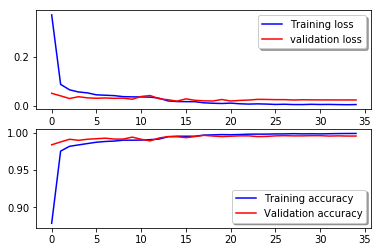

In [19]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [20]:
results = model.predict(test)

In [21]:
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [22]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)